<h1>Activity Classification based on Accelerometer Data</h1>

In [9]:
import numpy as np
import pandas as pd
import glob
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
import keras_tuner as kt
import matplotlib.pyplot as plt
import seaborn as sns

<h2>Preprocessing</h2>

In [10]:
names = ['subject-id', 'activity-code', 'timestamp', 'x', 'y', 'z']

path = r'wisdm-dataset/raw/phone/accel' # use your path
all_files = glob.glob(path + "/*.txt")

li = []

for filename in all_files:
    df = pd.read_csv(filename, names=names)
    li.append(df)

frame_phone_accel = pd.concat(li, axis=0, ignore_index=True)

frame_phone_accel['z'] = frame_phone_accel['z'].str.rstrip(';').astype(float)

In [11]:
X_train_full_phone_accel, X_test_phone_accel, y_train_full_phone_accel, y_test_phone_accel = train_test_split(frame_phone_accel[['timestamp', 'x', 'y', 'z']], frame_phone_accel[['timestamp', 'activity-code']], test_size=0.1, random_state=150, stratify=frame_phone_accel['subject-id'])
X_train_phone_accel, X_valid_phone_accel, y_train_phone_accel, y_valid_phone_accel = train_test_split(X_train_full_phone_accel, y_train_full_phone_accel, test_size=X_test_phone_accel.shape[0], random_state=150)

In [12]:
def convert_timestamp_to_datetime(X):
    return pd.to_datetime(X, unit='ns')

timestamp_transformer = FunctionTransformer(convert_timestamp_to_datetime)
time_pipeline = make_pipeline(timestamp_transformer)
X_train_full_phone_accel['timestamp'] = time_pipeline.fit_transform(X_train_full_phone_accel['timestamp'])
X_train_phone_accel['timestamp'] = time_pipeline.fit_transform(X_train_phone_accel['timestamp'])
X_valid_phone_accel['timestamp'] = time_pipeline.fit_transform(X_valid_phone_accel['timestamp'])
X_test_phone_accel['timestamp'] = time_pipeline.fit_transform(X_test_phone_accel['timestamp'])

y_train_full_phone_accel['timestamp'] = time_pipeline.fit_transform(y_train_full_phone_accel['timestamp'])
y_train_phone_accel['timestamp'] = time_pipeline.fit_transform(y_train_phone_accel['timestamp'])
y_valid_phone_accel['timestamp'] = time_pipeline.fit_transform(y_valid_phone_accel['timestamp'])
y_test_phone_accel['timestamp'] = time_pipeline.fit_transform(y_test_phone_accel['timestamp'])

In [13]:
num_sets = [X_train_phone_accel, X_valid_phone_accel, X_test_phone_accel]
cat_sets = [y_train_phone_accel, y_valid_phone_accel, y_test_phone_accel]

<h3>Due to limited computational resources, datasets will be shortened to every 1 minute</h3>

In [8]:
def set_index(df: pd.DataFrame):
    try:
        return df.set_index('timestamp', inplace=True)
    except:
        pass

def resample_num(df: pd.DataFrame):
    return df.resample('1min').mean()

def resample_cat(df: pd.DataFrame):
    return df.resample('1min').max()

for set in num_sets:
    set_index(set)

for set in cat_sets:
    set_index(set)

set_index(X_train_full_phone_accel)
X_train_full_phone_accel_resampled = resample_num(X_train_full_phone_accel)
X_train_phone_accel_resampled = resample_num(X_train_phone_accel)
X_valid_phone_accel_resampled = resample_num(X_train_phone_accel)
X_test_phone_accel_resampled = resample_num(X_test_phone_accel)

set_index(y_train_full_phone_accel)
y_train_full_phone_accel_resampled = resample_cat(y_train_full_phone_accel)
y_train_phone_accel_resampled = resample_cat(y_train_phone_accel)
y_valid_phone_accel_resampled = resample_cat(y_valid_phone_accel)
y_test_phone_accel_resampled = resample_cat(y_test_phone_accel)

In [14]:
num_imputer = SimpleImputer(strategy='constant', fill_value=0).set_output(transform='pandas')

X_train_full_phone_accel_resampled = num_imputer.fit_transform(X_train_full_phone_accel_resampled)
X_train_phone_accel_resampled = num_imputer.fit_transform(X_train_phone_accel_resampled)
X_valid_phone_accel_resampled = num_imputer.transform(X_valid_phone_accel_resampled)
X_test_phone_accel_resampled = num_imputer.transform(X_test_phone_accel_resampled)

In [15]:
X_train_full_phone_accel_resampled['activity-code'] = y_train_full_phone_accel_resampled['activity-code']

<h3>Exploratory Data Analysis</h3>

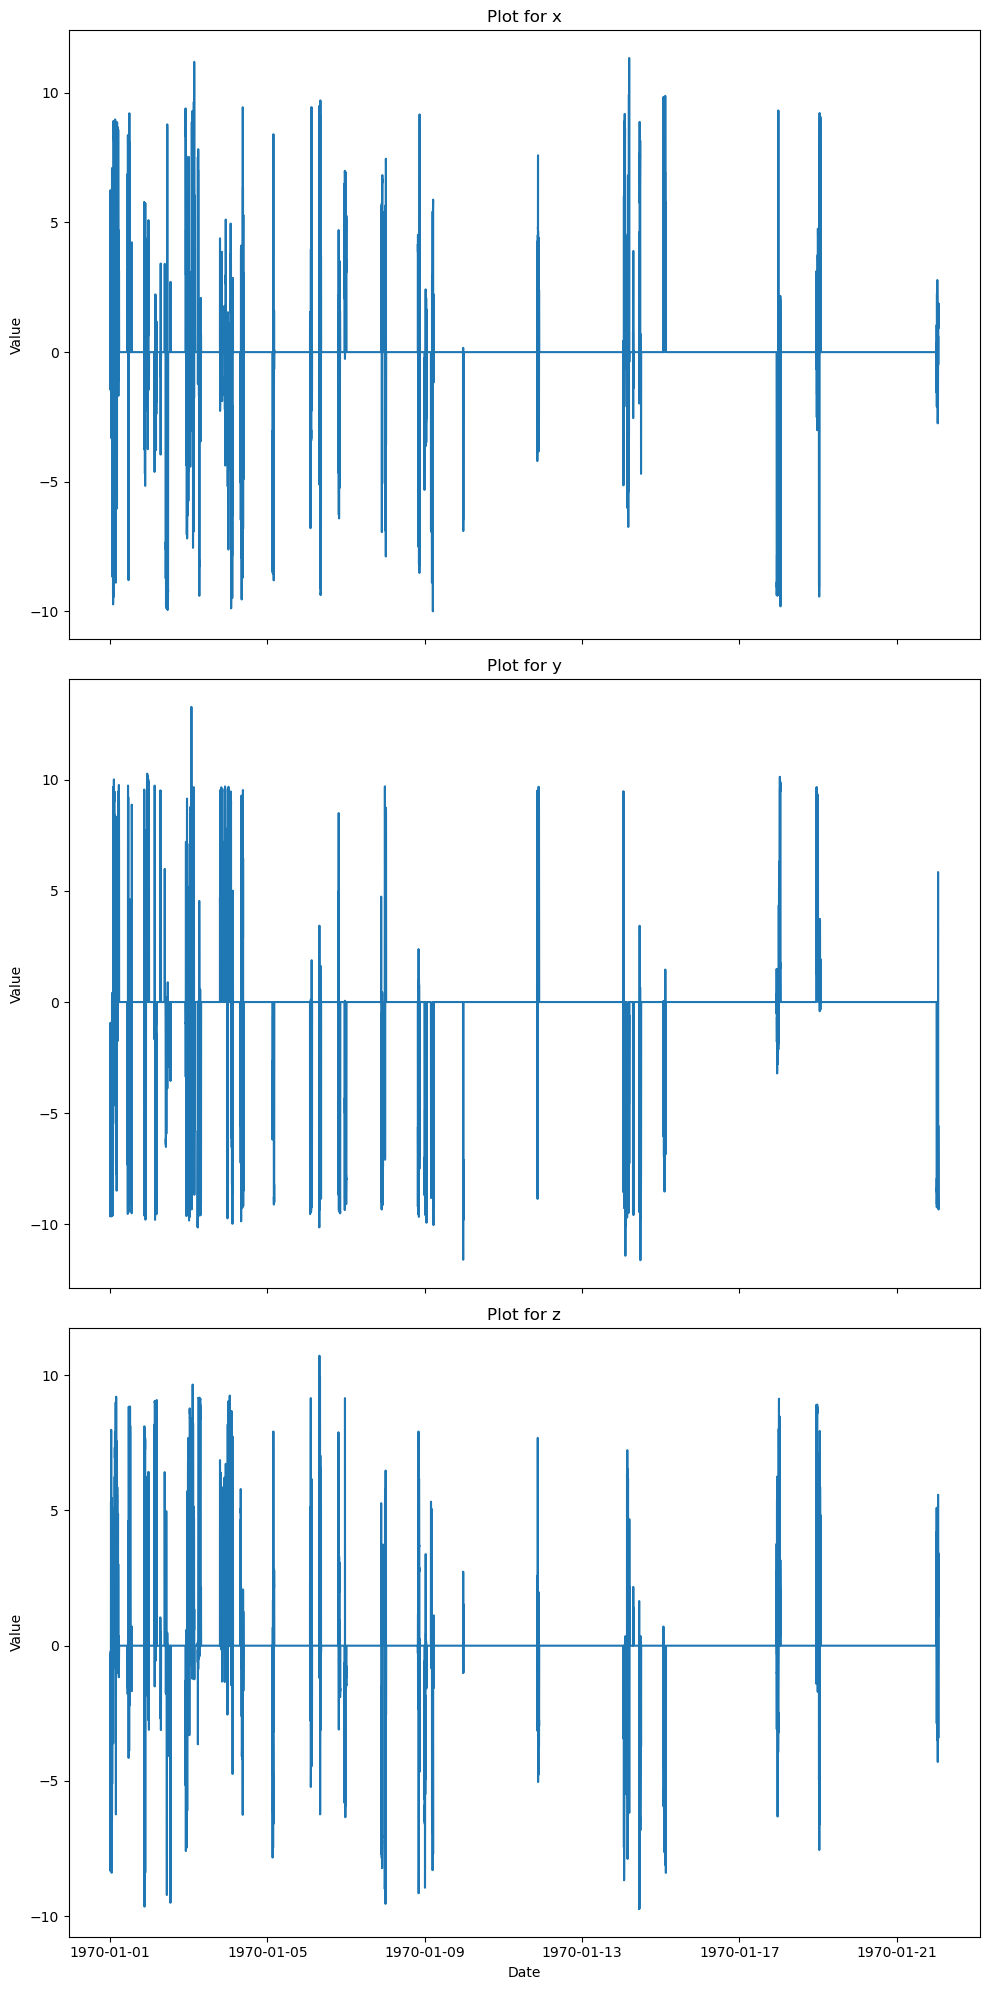

In [34]:
columns_to_plot = ['x', 'y', 'z']

# Create a figure and a grid of subplots with a fixed size
fig, axs = plt.subplots(nrows=len(columns_to_plot), ncols=1, figsize=(10, 20), sharex=True)

# Plot each column in a separate subplot
for i, column in enumerate(columns_to_plot):
    sns.lineplot(data=X_train_full_phone_accel_resampled, x=X_train_full_phone_accel_resampled.index, y=column, ax=axs[i])
    axs[i].set_title(f'Plot for {column}')
    axs[i].set_ylabel('Value')

# Set common x-axis label
plt.xlabel('Date')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()

<h3>Feature scaling and encoding</h3>

In [17]:
phone_accel_scaler = MinMaxScaler().set_output(transform='pandas')

scaled_X_train_phone_accel = phone_accel_scaler.fit_transform(X_train_phone_accel_resampled) 
scaled_X_valid_phone_accel = phone_accel_scaler.transform(X_valid_phone_accel_resampled)
scaled_X_test_phone_accel = phone_accel_scaler.transform(X_test_phone_accel_resampled)

In [18]:
encoder = OneHotEncoder(sparse_output=False).set_output(transform='pandas')
y_train_phone_accel_cat = encoder.fit_transform(y_train_phone_accel_resampled)
y_valid_phone_accel_cat = encoder.transform(y_valid_phone_accel_resampled)
y_test_phone_accel_cat = encoder.transform(y_test_phone_accel_resampled)

<h1>Hyperparameter Tuning</h1>

In [19]:
def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=1, max_value=5)
    n_neurons = hp.Int("n_neurons", min_value=10, max_value=100)
    learning_rate = hp.Float("learning_rate", min_value=1e-6, max_value=10, sampling="log")
    optimizer = hp.Choice("optimizer", values=["sgd", "rmsprop", "adam", "adamax", "nadam", "adamw"])

    if optimizer == "sgd":
        momentum = hp.Float('momentum', min_value=0, max_value=1)
        nesterov = hp.Boolean('nesterov')
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum, nesterov=nesterov)

    elif optimizer == "rmsprop":
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

    elif optimizer == "adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    elif optimizer == "adamax":
        optimizer = tf.keras.optimizers.Adamax(learning_rate=learning_rate)

    elif optimizer == "nadam":
        optimizer = tf.keras.optimizers.Nadam(learning_rate=learning_rate)

    else:
        optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate)


    phone_accel_inp = tf.keras.Input(shape=(3,))

    # Create dictionary to store hidden layers per input
    phone_accel_hidden_layer_dict = {}
    phone_accel_hidden_layer_dict['hidden1'] = tf.keras.layers.Dense(n_neurons, activation='relu')(phone_accel_inp)
    # Adds remaining n - 1 hidden layers
    for i in range(2, n_hidden + 1):
        phone_accel_hidden_layer_dict['hidden'+str(i)] = tf.keras.layers.Dense(n_neurons, activation='relu')(phone_accel_hidden_layer_dict['hidden'+str(i-1)])

    out = tf.keras.layers.Dense(19, activation='softmax', name='Activity')(phone_accel_hidden_layer_dict['hidden'+str(n_hidden)])

    model = tf.keras.Model(phone_accel_inp, out)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [20]:
# To be able to tune parameters in the .fit() model
class MyHyperModel(kt.HyperModel):
    def build(self, hp):
        return build_model(hp)
    
    def fit(self, hp, model, X, y, **kwargs):
        batch_size = hp.Int('batch_size', min_value=2, max_value=32)
        return model.fit(X, y, batch_size=batch_size, **kwargs)


In [21]:
bayesian_opt_tuner = kt.BayesianOptimization(MyHyperModel(), objective='val_accuracy', seed=150, max_trials=100, overwrite=False, directory='wisdm_hypermodel_trials', project_name='my_bayesian_search')
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

Reloading Tuner from wisdm_hypermodel_trials\my_bayesian_search\tuner0.json


In [13]:
bayesian_opt_tuner.search(scaled_X_train_phone_accel, y_train_phone_accel_cat, validation_data=(scaled_X_valid_phone_accel, y_valid_phone_accel_cat), epochs=500, callbacks=[early_stopping_cb])

Trial 5 Complete [00h 02m 17s]
val_accuracy: 0.004319583065807819

Best val_accuracy So Far: 0.9164111018180847
Total elapsed time: 01h 26m 42s

Search: Running Trial #6

Value             |Best Value So Far |Hyperparameter
2                 |4                 |n_hidden
91                |81                |n_neurons
0.00024894        |0.00029352        |learning_rate
adam              |rmsprop           |optimizer
0.78966           |0.8041            |momentum
False             |False             |nesterov
4                 |2                 |batch_size

Epoch 1/500
7582/7582 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.8925 - loss: 0.6500 - val_accuracy: 0.9113 - val_loss: 0.2977
Epoch 2/500
7582/7582 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.9102 - loss: 0.2994 - val_accuracy: 0.9125 - val_loss: 0.2809
Epoch 3/500
7582/7582 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.9128 - loss: 0.2732 - val_accuracy: 0.9138 - val_loss: 0.2694
Epoch 4/500
7582/7582 ━━━━━━━━━━━━━━━━━━━

Epoch 47/500
7582/7582 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.9232 - loss: 0.2280 - val_accuracy: 0.9227 - val_loss: 0.2358
Epoch 48/500
7582/7582 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.9238 - loss: 0.2295 - val_accuracy: 0.9241 - val_loss: 0.2360
Epoch 49/500
7582/7582 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.9229 - loss: 0.2299 - val_accuracy: 0.9238 - val_loss: 0.2351
Epoch 50/500
7582/7582 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.9222 - loss: 0.2359 - val_accuracy: 0.9236 - val_loss: 0.2364
Epoch 51/500
7582/7582 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.9231 - loss: 0.2311 - val_accuracy: 0.9233 - val_loss: 0.2348
Epoch 52/500
7582/7582 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.9241 - loss: 0.2292 - val_accuracy: 0.9233 - val_loss: 0.2353
Epoch 53/500
7582/7582 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.9209 - loss: 0.2348 - val_accuracy: 0.9239 - val_loss: 0.2350
Epoch 54/500
7582/7582 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 

In [22]:
best_model = bayesian_opt_tuner.get_best_models(num_models=1)[0]

c:\Users\Shaun\miniconda3\envs\WISDM\Lib\site-packages\keras\src\saving\saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 12 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [23]:
best_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 81)             │           324 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 81)             │         6,642 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 81)             │         6,642 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 81)             │         6,642 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Activity (Dense)                │ (None, 19)             │         1,558 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,808 (85.19 KB)

 Trainable params: 21,808 (85.19 KB)

 Non-trainable params: 0 (0.00 B)

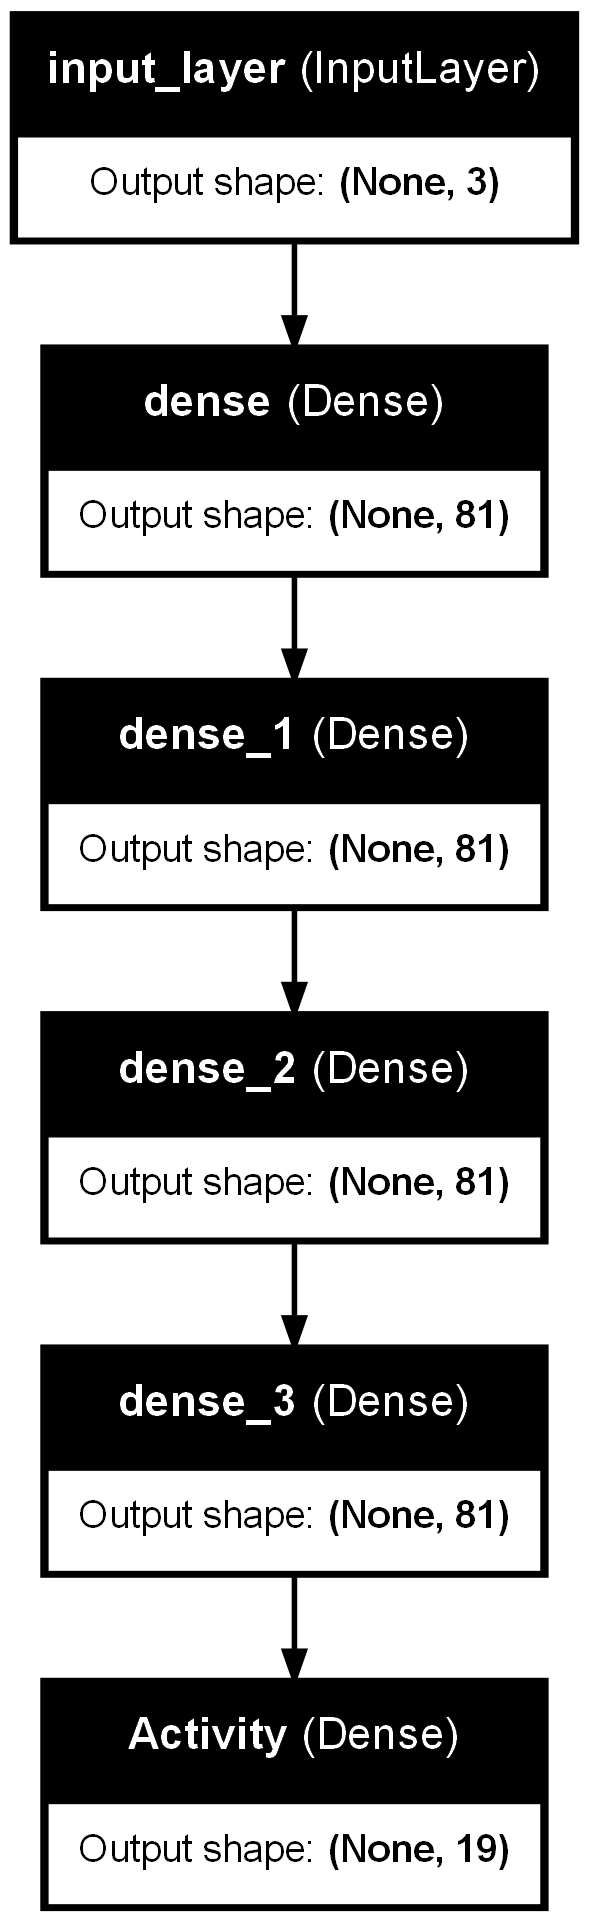

In [25]:
tf.keras.utils.plot_model(best_model, show_layer_names=True, show_shapes=True)

In [37]:
test_loss, test_accuracy = best_model.evaluate(scaled_X_test_phone_accel, y_train_phone_accel_cat)

948/948 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8392 - loss: 0.5088


In [39]:
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

Test loss: 0.2678755521774292
Test accuracy: 0.9162791967391968
